In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from envs.forked_riverswim import ForkedRiverSwim
from envs.riverswim import RiverSwim
from typing import Sequence, Dict, Tuple, Union, Literal, NamedTuple
from itertools import product
from numpy.typing import NDArray
import torch
import lzma
import pyximport
_ = pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)
from utils.cutils import policy_evaluation
from utils.utils import Results
from utils.new_mdp_description import NewMDPDescription
from scipy.stats import t
from make_agent import AgentType
from simulation_parameters import EnvType, SimulationParameters


def TV(p,q):
    return np.sum(np.abs(p-q), -1) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

    
compute_dist_omega = lambda x,y: TV(x,y)
compute_dist_value = lambda V, mdp: np.linalg.norm(V -mdp.V_greedy[np.newaxis, np.newaxis], axis=-1)

/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

In [3]:
lengths = [
    (5, EnvType.RIVERSWIM),
    (10, EnvType.RIVERSWIM),
    (20, EnvType.RIVERSWIM),
    #(30, EnvType.RIVERSWIM),
    (3, EnvType.FORKED_RIVERSWIM),
    (5, EnvType.FORKED_RIVERSWIM),
    (10, EnvType.FORKED_RIVERSWIM),
    #(15, EnvType.FORKED_RIVERSWIM),
    ]
#envs = [EnvType.RIVERSWIM, EnvType.FORKED_RIVERSWIM]
agents = [AgentType.Q_UCB, AgentType.Q_LEARNING,  AgentType.BAYESOBPI,
         AgentType.OBPI, AgentType.MDP_NAS, AgentType.BPI_NEW_BOUND, AgentType.BPI_NEW_BOUND_SIMPLIFIED_1#, AgentType.BPI_NEW_BOUND_BAYES
        ]
                        # AgentType.BPI_NEW_BOUND,  AgentType.OBPI, AgentType.PGOBPI,
                        # AgentType.BPI_NEW_BOUND_SIMPLIFIED_1, AgentType.MDP_NAS]
                        


class DataResults(NamedTuple):
    simulation_parameters: SimulationParameters
    agent_type: AgentType
    data: Sequence[Sequence[Results]]

data: Dict[Tuple[int, EnvType, AgentType],  DataResults] = {}
for env_type, agent in product(lengths, agents):
    length, env = env_type
    data[(length, env, agent)] = None
    
        
    with lzma.open(f'data/{env.value}/{agent.value}_{length}.pkl.lzma', 'rb') as f:
        res  = pickle.load(f)
        data[(length, env, agent)] = DataResults(res['simulation_parameters'], res['agent_type'], res['data'])



In [4]:
class SequencedResults(NamedTuple):
    omega: NDArray[np.float64]
    greedy_policy: NDArray[np.int64]
    total_state_visits: NDArray[np.float64]
    last_visit: NDArray[np.float64]
    exp_visits: NDArray[np.float64]
    eval_greedy: NDArray[np.float64]
    dist_omega: NDArray[np.float64]
    U_omega: NDArray[np.float64]
    dist_value: NDArray[np.float64]
    elapsed_times: NDArray[np.float64]



def get_data(data: DataResults, true_mdp: NewMDPDescription, true_omega: NDArray[np.float64]) -> SequencedResults:
    data_omega = []
    num_visits = []
    policies = []
    last_visit = []
    visits = []
    eval_greedy = []
    elapsed_times = []
    for i in range(data.simulation_parameters.n_sims):
        _, _data_omega, _greedy_policy, _num_visits, _last_visit, _visits, _eval_greedy, _elapsed_times = zip(*data.data[i])
        data_omega.append(_data_omega)
        num_visits.append(_num_visits)
        policies.append(_greedy_policy)
        last_visit.append(_last_visit)
        visits.append(_visits)
        eval_greedy.append(_eval_greedy)
        elapsed_times.append(_elapsed_times)
    
    data_omega = np.array(data_omega)
    num_visits = np.array(num_visits)
    policies = np.array(policies)
    last_visit = np.array(last_visit)
    visits = np.array(visits)
    eval_greedy = np.array(eval_greedy)
    elapsed_times = np.array(elapsed_times)

    
    omega = data_omega.reshape(data_omega.shape[0], data_omega.shape[1], -1)

    dist_omega = compute_dist_omega(omega, true_omega.flatten()[np.newaxis, np.newaxis, ...])
    U_omega = eval_allocations(omega, true_mdp, true_mdp.Q_greedy.shape[1])
    dist_value = compute_dist_value(eval_greedy, true_mdp)
    
    return SequencedResults(data_omega, policies, num_visits, last_visit, visits, eval_greedy, dist_omega, U_omega, dist_value, elapsed_times)


def eval_allocations(allocation, mdp, num_actions):
    eval_x = np.zeros((allocation.shape[0], allocation.shape[1]))
    for i in range(allocation.shape[0]):
        for j in range(allocation.shape[1]):
            eval_x[i,j] = mdp.evaluate_allocation(allocation[i,j].reshape(-1, num_actions))
            if np.isinf(eval_x[i,j]):
                eps = 1e-3
                U = np.ones_like(allocation[i,j].reshape(-1, num_actions)) / np.prod(allocation[i,j].shape)
                omega = (1-eps) * allocation[i,j].reshape(-1, num_actions) + eps * U
                eval_x[i,j] = mdp.evaluate_allocation(omega)
    return eval_x


In [5]:
parsed_data: Dict[Tuple[int, EnvType, AgentType],  SequencedResults] = {}

for length, env_type in lengths:
    if env_type == EnvType.FORKED_RIVERSWIM:
        env = ForkedRiverSwim(length)
    else:
        env = RiverSwim(length)
    mdp = NewMDPDescription(env.transitions, env.rewards, 0.99)
    true_omega, _ = mdp.compute_allocation(navigation_constraints=True)
        
    for agent in agents:
        print(f'> Evaluating {env_type.value}/{length}/{agent.value}')
        single_data = data[(length, env_type, agent)]
       
        parsed_data[(length, env_type, agent)] = get_data(single_data, mdp, true_omega)


> Evaluating Riverswim/5/Q-UCB
> Evaluating Riverswim/5/Q-Learning
> Evaluating Riverswim/5/Bayes-O-BPI
> Evaluating Riverswim/5/O-BPI
> Evaluating Riverswim/5/MDP-NaS
> Evaluating Riverswim/5/BPI
> Evaluating Riverswim/5/BPISimplified - 1
> Evaluating Riverswim/10/Q-UCB
> Evaluating Riverswim/10/Q-Learning
> Evaluating Riverswim/10/Bayes-O-BPI
> Evaluating Riverswim/10/O-BPI
> Evaluating Riverswim/10/MDP-NaS
> Evaluating Riverswim/10/BPI


/home/alessior/rl-exploration-maze/RiverSwimExperiments/utils/new_mdp_description.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  T1 = self.normalizer * (2 + 8 * golden_ratio_sq * self.Mk_V_greedy[s,a]) / (omega[s,a] * self.delta_sq[s,a])
/home/alessior/rl-exploration-maze/RiverSwimExperiments/utils/new_mdp_description.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  T2 = self.normalizer * C/ (omega[sp, self.pi_greedy[sp]] * self.delta_sq[s,a] * ((1 - self.discount_factor) ** 2))


> Evaluating Riverswim/10/BPISimplified - 1
> Evaluating Riverswim/20/Q-UCB
> Evaluating Riverswim/20/Q-Learning
> Evaluating Riverswim/20/Bayes-O-BPI
> Evaluating Riverswim/20/O-BPI
> Evaluating Riverswim/20/MDP-NaS
> Evaluating Riverswim/20/BPI
> Evaluating Riverswim/20/BPISimplified - 1
> Evaluating ForkedRiverswim/3/Q-UCB
> Evaluating ForkedRiverswim/3/Q-Learning
> Evaluating ForkedRiverswim/3/Bayes-O-BPI
> Evaluating ForkedRiverswim/3/O-BPI
> Evaluating ForkedRiverswim/3/MDP-NaS
> Evaluating ForkedRiverswim/3/BPI
> Evaluating ForkedRiverswim/3/BPISimplified - 1
> Evaluating ForkedRiverswim/5/Q-UCB
> Evaluating ForkedRiverswim/5/Q-Learning
> Evaluating ForkedRiverswim/5/Bayes-O-BPI
> Evaluating ForkedRiverswim/5/O-BPI
> Evaluating ForkedRiverswim/5/MDP-NaS
> Evaluating ForkedRiverswim/5/BPI
> Evaluating ForkedRiverswim/5/BPISimplified - 1
> Evaluating ForkedRiverswim/10/Q-UCB
> Evaluating ForkedRiverswim/10/Q-Learning
> Evaluating ForkedRiverswim/10/Bayes-O-BPI
> Evaluating ForkedR

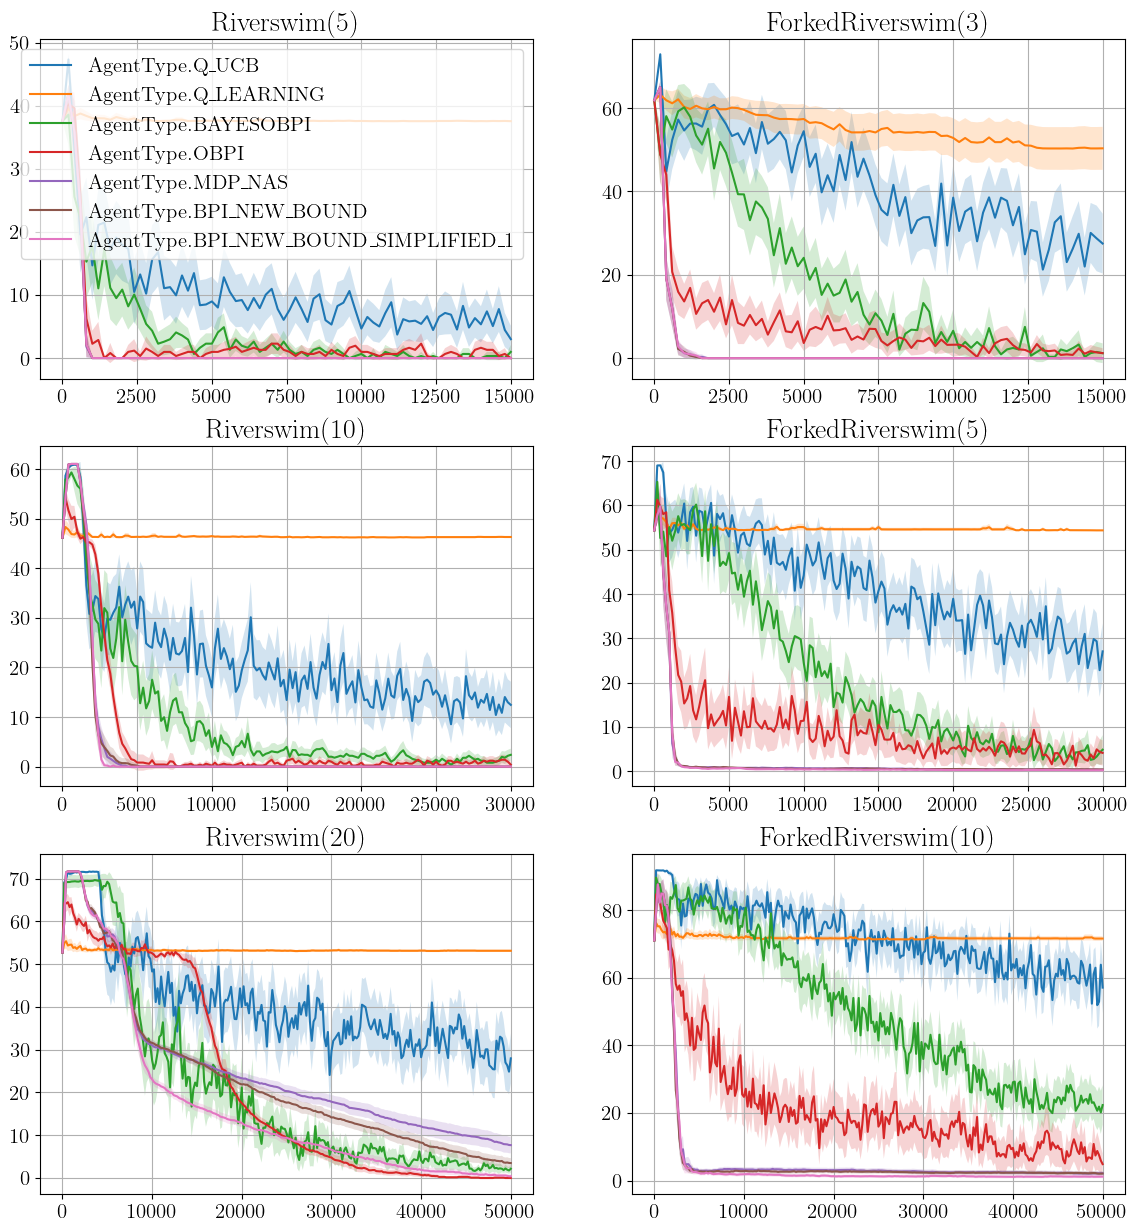

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(14, 15))

id_l = 0
for length, env_type in lengths:
    id_e = 0 if env_type == EnvType.RIVERSWIM else 1
    if env_type == EnvType.RIVERSWIM:
        id_l = 0 if length == 5 else 1 if length == 10 else 2 if length == 20 else 3
    else:
        id_l = 0  if length == 3 else 1 if length == 5 else 2 if length == 10 else 3
    for agent in agents:
        parameters=  data[(length, env_type, agent)].simulation_parameters
        x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

        mu, ce = CE(parsed_data[(length, env_type, agent)].dist_value)
        ax[id_l, id_e].plot(x, mu, label=agent)
        ax[id_l, id_e].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[id_l, id_e].grid()
    ax[id_l, id_e].set_title(f'{env_type.value}({length})')

ax[0,0].legend()
# ax[0, 0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')
# ax[0, 1].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')



# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPI-GEN',  'QLEARNING', 'QUCB', 'MFBPIUCB']:
#     mu, ce = CE(results[agent].dist_value)
#     ax[0].plot(x, mu, label=agent)
#     ax[0].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')

# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:    
#     mu, ce = CE(results[agent].dist_omega)
#     ax[1].plot(x, mu, label=agent)
#     ax[1].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[1].set_title(r'$TV(\omega_t,\omega_{nc}^\star)$')

# ax[1].set_yscale('log')


# for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:
#     mu, ce = CE(np.log10(results[agent].U_omega  / U))
#     ax[2].plot(x, mu, label=agent)
#     ax[2].fill_between(x, mu-ce, mu+ce, alpha=0.2)
#     ax[2].set_title(r'$U(\omega_t)/U(\omega_{nc}^\star)$')
# #ax[2].set_yscale("log")

# for i in range(3):
#     ax[i].set_xlabel('$t$')
#     ax[i].grid()

# ax[0].legend(ncols=7, bbox_to_anchor=(3.5, -0.2), frameon=False,fontsize=14, borderpad=0.1, labelspacing=0.1, handlelength=1)
plt.savefig('figures/plot28.pdf')
plt.show()


In [7]:
len(range(0, 15001, 50))

301